<a href="https://colab.research.google.com/github/sv650s/atp-tennis-predictions/blob/dataset2/notebooks/5.0.0-classification-1layer_nn-2xfeatures-ordinal-history5_win_perc-stats5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATP Tennis Data - NN Using One Hot Encoding

In this notebook, I we will run our data through a 1 layer NN where number of hidden units is 2x number of features

Columns that will be used in this notebook are:
* raw ordinal features -ie, p1/p2_rank, p1/p2_height
* history win percentage for each player for the last 5 maches
* raw player stats from last 5 maches

We will compare the results of the NN with the Gradient Boosting model

```
Model Score: 0.6829169480081027

ROC/AUC Score: 0.6829166839061929
              precision    recall  f1-score   support

        Loss       0.68      0.68      0.68     14815
         Win       0.68      0.68      0.68     14805

    accuracy                           0.68     29620
   macro avg       0.68      0.68      0.68     29620
weighted avg       0.68      0.68      0.68     29620
```

# Results

This NN architecture has about the same accuracy of our baseline model with Decision Tress where we only use the difference in player rank as a features

Accuracy for this model is: 0.6542538825118164

```
              precision    recall  f1-score   support

        loss       0.66      0.66      0.66     14890
         win       0.65      0.65      0.65     14730

    accuracy                           0.65     29620
   macro avg       0.65      0.65      0.65     29620
weighted avg       0.65      0.65      0.65     29620
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

TensorFlow 2.x selected.


'/device:GPU:0'

In [3]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD

# add our google drive directory to path so we can load custom modules
DRIVE_DIR = "drive/My Drive/Springboard/capstone2"
sys.path.append(DRIVE_DIR)
import util.model_util as mu
from util.model_util import LABEL_COL, RSTATE


logging.basicConfig(level=logging.INFO)
%matplotlib inline
sns.set()

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
DATASET_DIR = f'{DRIVE_DIR}/datasets'
MODEL_DIR = f'{DRIVE_DIR}/models'
REPORT_DIR = f'{DRIVE_DIR}/reports'

START_YEAR = 1998
END_YEAR = 2018

DEBUG = False
MODEL_NAME = 'nn_1layer-2xfeatures-ordinal-history5_win_perc-stats5'
mu.ModelWrapper.MODEL_DIR = f'{DRIVE_DIR}/models'


if DEBUG:
  FEATURE_FILE = f'{DATASET_DIR}/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
  MODEL_NAME = f'{MODEL_NAME}-test'
  mu.ModelWrapper.REPORT_FILE = f'{DRIVE_DIR}/reports/summary-test.csv'
else:
  FEATURE_FILE = f'{DATASET_DIR}/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'
  mu.ModelWrapper.REPORT_FILE = f'{DRIVE_DIR}/reports/summary.csv'


In [5]:
filters = ["util.model_util.BaseOrdinalFilter", "util.model_util.History5WinPercentageFilter", "util.model_util.Stats5RawFilter"]
MODEL_BASENAME = f'{MODEL_DIR}/{MODEL_NAME}'


features, labels = mu.ModelWrapper.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, column_filters = filters,
                                                split_train_test = False)
print(features.shape)
print(features.info())
features.head()

INFO:util.model_util:Adding filter: util.model_util.BaseOrdinalFilter
INFO:util.model_util:Adding filter: util.model_util.History5WinPercentageFilter
INFO:util.model_util:Adding filter: util.model_util.Stats5RawFilter
INFO:util.model_util:loading drive/My Drive/Springboard/capstone2/datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv
INFO:util.model_util:Shape before filtering: (118478, 5464)
INFO:util.model_util:Shape after filtering: (118478, 31)
INFO:util.model_util:Final Features shape: (118478, 31)


(118478, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 118478 entries, 81324 to 199801
Data columns (total 31 columns):
draw_size                     118478 non-null int64
round_label                   118478 non-null int64
tourney_level_label           118478 non-null int64
tourney_month                 118478 non-null int64
tourney_year                  118478 non-null int64
p1_age                        118478 non-null float64
p1_ht                         118478 non-null float64
p1_rank                       118478 non-null int64
p2_age                        118478 non-null float64
p2_ht                         118478 non-null float64
p2_rank                       118478 non-null int64
p1_history5_win_percentage    118478 non-null float64
p2_history5_win_percentage    118478 non-null float64
p1_stats5_1stin               118478 non-null int64
p1_stats5_1stwon              118478 non-null int64
p1_stats5_2ndwon              118478 non-null int64
p1_stats5_ace               

,draw_size,round_label,tourney_level_label,tourney_month,tourney_year,p1_age,p1_ht,p1_rank,p2_age,p2_ht,p2_rank,p1_history5_win_percentage,p2_history5_win_percentage,p1_stats5_1stin,p1_stats5_1stwon,p1_stats5_2ndwon,p1_stats5_ace,p1_stats5_bpfaced,p1_stats5_bpsaved,p1_stats5_df,p1_stats5_svgms,p1_stats5_svpt,p2_stats5_1stin,p2_stats5_1stwon,p2_stats5_2ndwon,p2_stats5_ace,p2_stats5_bpfaced,p2_stats5_bpsaved,p2_stats5_df,p2_stats5_svgms,p2_stats5_svpt
81324,32,5,4,1,1998,25.79,183.0,4,26.61,188.0,74,0.6,0.4,36,26,14,6,6,4,2,9,65,45,31,16,4,7,4,2,12,76
81325,32,5,4,1,1998,26.61,188.0,74,25.79,183.0,4,0.4,0.6,45,31,16,4,7,4,2,12,76,36,26,14,6,6,4,2,9,65
81326,32,5,4,1,1998,27.76,185.0,79,22.85,175.0,87,0.4,0.4,43,33,20,8,6,3,3,13,82,46,26,10,0,8,3,3,10,68
81327,32,5,4,1,1998,22.85,175.0,87,27.76,185.0,79,0.4,0.4,46,26,10,0,8,3,3,10,68,43,33,20,8,6,3,3,13,82
81328,32,5,4,1,1998,21.76,185.0,93,23.08,185.0,71,0.4,0.2,38,27,13,5,7,5,1,9,64,39,31,11,9,4,2,2,11,68


In [6]:
# one hot encode our labels for Keras
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
labels_encoded = label_encoder.fit_transform(pd.DataFrame(labels))
labels_encoded[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [0]:
# split into training and test set
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(features, labels_encoded)
y_test = label_encoder.inverse_transform(y_test_encoded)

In [8]:
X_train.shape

(88858, 31)

# Implement Neural Network




In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow.keras as K

RSTATE = 1

output_dim = nb_classes = 2
model_lr = Sequential() 
model_lr.add(Dense(X_train.shape[1] * 3, 
                   input_shape=(X_train.shape[1], ),
                   kernel_regularizer=regularizers.l2(0.01),
                   kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
model_lr.add(BatchNormalization())
model_lr.add(Activation("relu"))


model_lr.add(Dense(output_dim, 
                   kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
model_lr.add(Activation("softmax"))
batch_size = 129 
epochs = 100

model_lr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) 

model_json = model_lr.to_json()
with open(f'{MODEL_BASENAME}.json', 'w') as file:
  file.write(model_json)

model_lr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 93)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 93)                372       
_________________________________________________________________
activation (Activation)      (None, 93)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 188       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 3,536
Trainable params: 3,350
Non-trainable params: 186
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
             ModelCheckpoint(filepath=f'{MODEL_BASENAME}.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001, mode='auto')]


history = model_lr.fit(X_train, y_train_encoded, 
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1, 
                       validation_split=0.2,
                       callbacks=callbacks) 

# evalute our model
score = model_lr.evaluate(X_test, y_test_encoded, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 71086 samples, validate on 17772 samples
Epoch 1/100
71086/71086 [==============================] - 3s 49us/sample - loss: 1.0661 - accuracy: 0.6346 - val_loss: 1.1219 - val_accuracy: 0.5721
Epoch 2/100
71086/71086 [==============================] - 3s 39us/sample - loss: 0.9699 - accuracy: 0.6462 - val_loss: 1.0260 - val_accuracy: 0.5813
Epoch 3/100
71086/71086 [==============================] - 3s 38us/sample - loss: 0.9006 - accuracy: 0.6478 - val_loss: 0.8758 - val_accuracy: 0.6420
Epoch 4/100
71086/71086 [==============================] - 3s 39us/sample - loss: 0.8458 - accuracy: 0.6497 - val_loss: 0.8357 - val_accuracy: 0.6363
Epoch 5/100
71086/71086 [==============================] - 3s 38us/sample - loss: 0.8014 - accuracy: 0.6496 - val_loss: 0.8097 - val_accuracy: 0.6274
Epoch 6/100
71086/71086 [==============================] - 3s 38us/sample - loss: 0.7664 - accuracy: 0.6492 - val_loss: 0.8746 - val_accuracy: 0.5594
Epoch 7/100
71086/71086 [=========================

Test score: 0.6312320396354438
Test accuracy: 0.65486157


In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

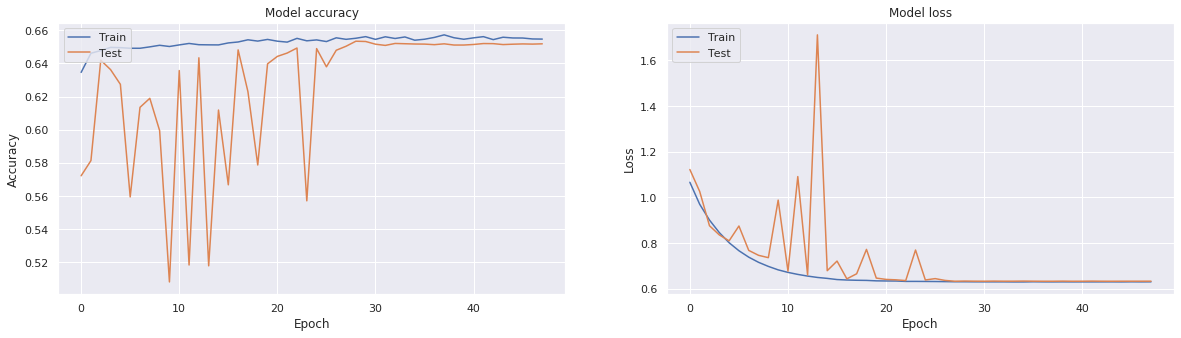

In [12]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

# Plot training & validation accuracy values
a[0].plot(history.history['accuracy'])
a[0].plot(history.history['val_accuracy'])
a[0].set_title('Model accuracy')
a[0].set_ylabel('Accuracy')
a[0].set_xlabel('Epoch')
a[0].legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
a[1].plot(history.history['loss'])
a[1].plot(history.history['val_loss'])
a[1].set_title('Model loss')
a[1].set_ylabel('Loss')
a[1].set_xlabel('Epoch')
a[1].legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# use our model to predict
y_predict_encoded = model_lr.predict(X_test)


In [14]:
y_predict_encoded[:20]

array([[0.5816319 , 0.41836807],
       [0.5708424 , 0.42915756],
       [0.32084906, 0.67915094],
       [0.70089144, 0.29910856],
       [0.6188038 , 0.38119626],
       [0.46538922, 0.5346108 ],
       [0.5708827 , 0.42911735],
       [0.5587439 , 0.4412561 ],
       [0.3329086 , 0.66709137],
       [0.23588973, 0.76411027],
       [0.44568932, 0.5543107 ],
       [0.28771198, 0.7122881 ],
       [0.39226764, 0.6077324 ],
       [0.38888773, 0.61111224],
       [0.28425714, 0.7157429 ],
       [0.6232315 , 0.3767685 ],
       [0.61337817, 0.3866218 ],
       [0.4223735 , 0.5776265 ],
       [0.55678684, 0.44321316],
       [0.83247185, 0.16752817]], dtype=float32)

In [15]:
y_predict = [row.idxmax() for index, row in pd.DataFrame(y_predict_encoded).iterrows()]
y_predict[:20]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]

In [0]:

mw = mu.ModelWrapper(model_lr, MODEL_NAME, FEATURE_FILE, START_YEAR, END_YEAR, 
                  X_train = X_train, 
                  y_train = label_encoder.inverse_transform(y_train_encoded), 
                  X_test = X_test, y_test = y_test, model_name = MODEL_NAME)
mw.y_predict = y_predict

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Model Score: 0.6548615800135044

ROC/AUC Score: 0.654897160828065
              precision    recall  f1-score   support

        Loss       0.65      0.66      0.65     14607
         Win       0.66      0.65      0.66     15013

    accuracy                           0.65     29620
   macro avg       0.65      0.65      0.65     29620
weighted avg       0.65      0.65      0.65     29620

      Loss   Win
Loss  9604  5003
Win   5220  9793


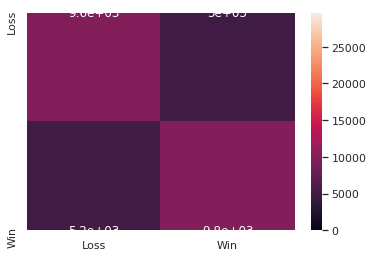

In [17]:
mw.analyze()

In [18]:
mw.save(save_model = False)

Saving report: drive/My Drive/Springboard/capstone2/reports/summary.csv


In [19]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-11-01 23:46
